<a href="https://colab.research.google.com/github/abubakerKhaled/Cars-Classification/blob/main/01_VGG19_From_Scratch_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import random
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive

drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/StanfordCars_Project'
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
DATA_PATH = os.path.join(PROJECT_PATH, 'stanford_cars_top20')

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if os.path.exists(DATA_PATH):
    print(f"Found data at: {DATA_PATH}")
    full_dataset = datasets.ImageFolder(root=DATA_PATH)
    targets = full_dataset.targets
    class_names = full_dataset.classes

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

    class CustomDataset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform: x = self.transform(x)
            return x, y
        def __len__(self):
            return len(self.subset)

    train_dataset = CustomDataset(Subset(full_dataset, train_idx), transform=train_transform)
    val_dataset = CustomDataset(Subset(full_dataset, val_idx), transform=val_transform)

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    print("Data Ready.")
else:
    print("Error: Check Data Path")

Mounted at /content/drive
Found data at: /content/drive/MyDrive/StanfordCars_Project/stanford_cars_top20
Data Ready.


In [14]:
import torch
import torch.nn as nn

class VGG19_Scratch(nn.Module):
    def __init__(self, num_classes=20):
        super(VGG19_Scratch, self).__init__()

        self.layer_config = [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 256, 256, 'M',
            512, 512, 512, 512, 'M',
            512, 512, 512, 512, 'M'
        ]

        self.features = self._make_layers(self.layer_config)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)

        x = torch.flatten(x, 1)

        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3

        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


model = VGG19_Scratch(num_classes=20)
dummy_image = torch.randn(1, 3, 224, 224)
output = model(dummy_image)

print(f"Input Shape: {dummy_image.shape}")
print(f"Output Shape: {output.shape}")

Input Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 20])


In [11]:
import time
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Training on device: {device}")
    print("-" * 30)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trained_vgg, vgg_history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=15
)

Training on device: cuda
------------------------------
Epoch 1/15
----------
train Loss: 3.1488 Acc: 0.0489
val Loss: 3.0603 Acc: 0.0684

Epoch 2/15
----------
train Loss: 3.1107 Acc: 0.0542
val Loss: 3.4426 Acc: 0.0632

Epoch 3/15
----------
train Loss: 3.0217 Acc: 0.0713
val Loss: 3.0687 Acc: 0.0789

Epoch 4/15
----------
train Loss: 3.0244 Acc: 0.0700
val Loss: 2.9690 Acc: 0.1105

Epoch 5/15
----------
train Loss: 2.9767 Acc: 0.0938
val Loss: 2.9542 Acc: 0.0895

Epoch 6/15
----------
train Loss: 2.9243 Acc: 0.1044
val Loss: 2.9559 Acc: 0.0947

Epoch 7/15
----------
train Loss: 2.9040 Acc: 0.1083
val Loss: 2.9951 Acc: 0.1000

Epoch 8/15
----------
train Loss: 2.8645 Acc: 0.1189
val Loss: 2.8982 Acc: 0.1421

Epoch 9/15
----------
train Loss: 2.8569 Acc: 0.1347
val Loss: 2.8511 Acc: 0.1421

Epoch 10/15
----------
train Loss: 2.8088 Acc: 0.1400
val Loss: 2.9096 Acc: 0.0789

Epoch 11/15
----------
train Loss: 2.7860 Acc: 0.1598
val Loss: 2.8529 Acc: 0.1526

Epoch 12/15
----------
train 

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

def evaluate_and_save(model, history, val_loader, class_names, save_name):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history['train_acc'], label='Train Accuracy')
    ax[0].plot(history['val_acc'], label='Val Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history['train_loss'], label='Train Loss')
    ax[1].plot(history['val_loss'], label='Val Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig(f"{RESULTS_PATH}/{save_name}_curves.png")
    plt.show()

    print("Generating Detailed Report...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {save_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{RESULTS_PATH}/{save_name}_cm.png")
    plt.show()


    model_save_path = f"{MODELS_PATH}/{save_name}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to: {model_save_path}")

    final_data = {
        "history": history,
        "report": report_dict
    }

    json_path = f"{RESULTS_PATH}/{save_name}_metrics.json"
    with open(json_path, 'w') as f:
        json.dump(final_data, f)
    print(f"Metrics saved to: {json_path}")

    return final_data

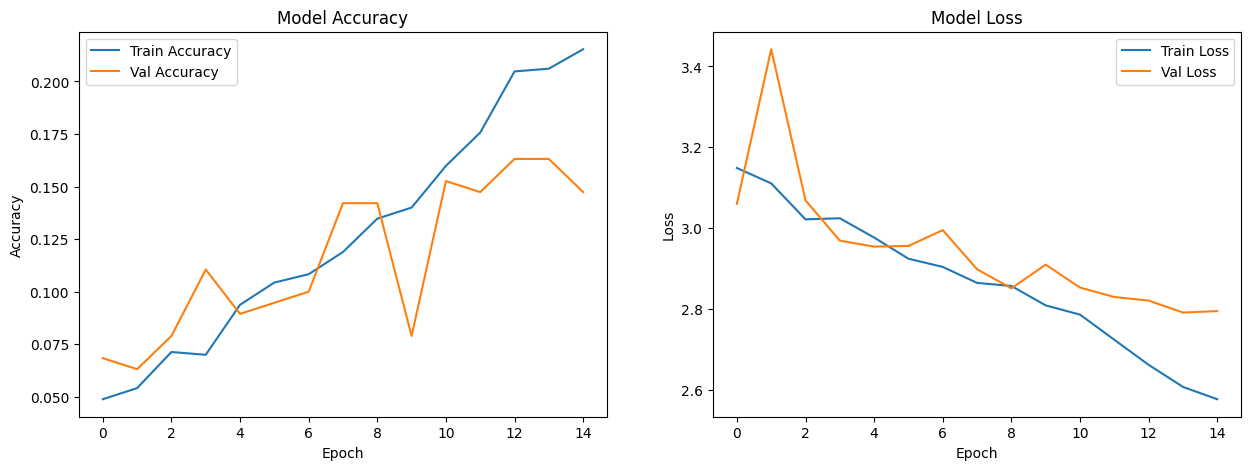

Generating Detailed Report...
                                          precision    recall  f1-score   support

                      Audi S6 Sedan 2011       0.14      0.33      0.20         9
       Bentley Continental GT Coupe 2007       0.00      0.00      0.00         9
     Cadillac Escalade EXT Crew Cab 2007       0.33      0.22      0.27         9
             Chevrolet Corvette ZR1 2012       0.00      0.00      0.00        10
             Chevrolet Malibu Sedan 2007       0.36      0.44      0.40         9
                 Chrysler 300 SRT-8 2010       0.00      0.00      0.00        10
                  Dodge Durango SUV 2007       0.25      0.33      0.29         9
              Eagle Talon Hatchback 1998       0.00      0.00      0.00         9
                      Ford GT Coupe 2006       0.10      0.11      0.11         9
                     GMC Savana Van 2012       0.33      0.29      0.31        14
              Geo Metro Convertible 1993       0.30      0.78      

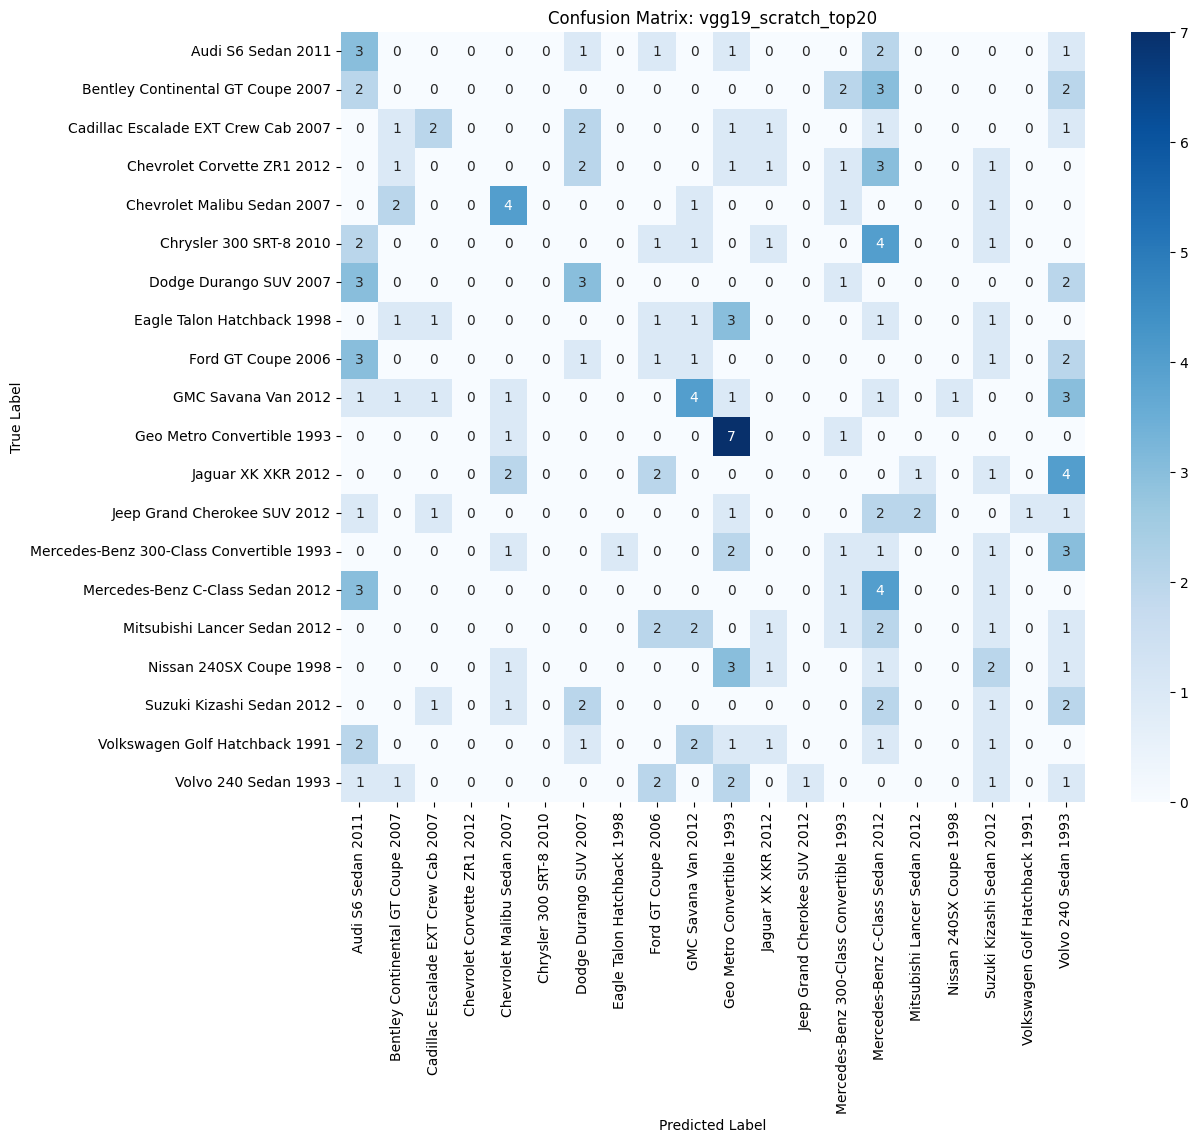

Model weights saved to: /content/drive/MyDrive/StanfordCars_Project/models/vgg19_scratch_top20.pth
Metrics saved to: /content/drive/MyDrive/StanfordCars_Project/results/vgg19_scratch_top20_metrics.json


In [17]:


metrics_data = evaluate_and_save(
    trained_vgg,
    vgg_history,
    val_loader,
    full_dataset.classes,
    "vgg19_scratch_top20"
)